# POT-GP fitting

This example shows the POT-GP fitting to derive the extreme event, including threshold determination.

---

Load the packages

In [1]:
import pandas as pd
import pybtls as pb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto

We generate 100-year traffic data (250 business days per year) first, with an initial threshold (u) of 1500.0 kNm. 

The simulation setup follows a similar logic to the previous Simulation with Traffic Generation example, but is simplified.

In [ ]:
# Define the influence line
le = pb.InfluenceLine("built-in")
le.set_IL(id = 1, length = 20.0)

# Set bridge
bridge = pb.Bridge(length=20.0, no_lane=2)
bridge.add_load_effect(inf_line_surf=le, threshold=1500.0)

# Set vehicle generator
garage = pb.garage.read_garage_file("./garage.txt", 4)
kernel = [[1.0, 0.08], [1.0, 0.05], [1.0, 0.02]]
vehicle_gen = pb.VehicleGenGarage(garage=garage, kernel=kernel)

# Set headway generator
headway_gen = pb.HeadwayGenFreeflow()

# Set lane flow compositions
normalized_hourly_flow_truck = [0.019947, 0.019947, 0.019947, 0.019947, 0.019947, 0.031915, 0.059840, 0.059840, 0.059840, 0.055851, 0.046543, 0.046543, 0.046543, 0.046543, 0.046543, 0.055851, 0.055851, 0.055851, 0.055851, 0.046543, 0.046543, 0.031915, 0.031915, 0.019947]
normalized_hourly_flow_car = [0.005721, 0.005721, 0.005721, 0.005721, 0.005721, 0.014874, 0.088673, 0.145881, 0.117277, 0.061785, 0.037185, 0.037185, 0.037185, 0.037185, 0.037185, 0.061785, 0.061785, 0.061785, 0.061785, 0.037185, 0.037185, 0.014874, 0.014874, 0.005721]

lfc_1 = pb.LaneFlowComposition(lane_index=1, lane_dir=1)
lfc_1.assign_lane_data(
    hourly_truck_flow = [
        round(i * 2500) for i in normalized_hourly_flow_truck
    ], 
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [5.0] * 24,  # in dm/s
)

lfc_2 = pb.LaneFlowComposition(lane_index=2, lane_dir=1)
lfc_2.assign_lane_data(
    hourly_truck_flow = [
        round(i * 625) for i in normalized_hourly_flow_truck
    ],
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [10.0] * 24,  # in dm/s
)    

# Set traffic generator
traffic_gen = pb.TrafficGenerator(no_lane=2)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_1)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_2)

# Selet outputs
output_config = pb.OutputConfig()
output_config.set_POT_output(
    write_summary = True,
    POT_size_days = 250,
)

# Create and run the simulation
sim_task = pb.Simulation("./temp")
sim_task.add_sim(
    bridge = bridge,
    traffic = traffic_gen,
    no_day = 250*100,
    output_config = output_config,
    time_step = 0.1,
    tag = "Case6",
)
sim_task.run(no_core = 1)

# Get and save the output data
example_output = sim_task.get_output()
pb.save_output(example_output, "example_output_POT.pkl")

Read the POT output data.

In [21]:
example_output = pb.load_output("example_output_POT.pkl")
POT_output = example_output["Case6"].read_data("POT_summary")["PT_S_20_Eff_1"]

Outputs have been successfully loaded from example_output_POT.pkl!


Make a plot for the POT data. 

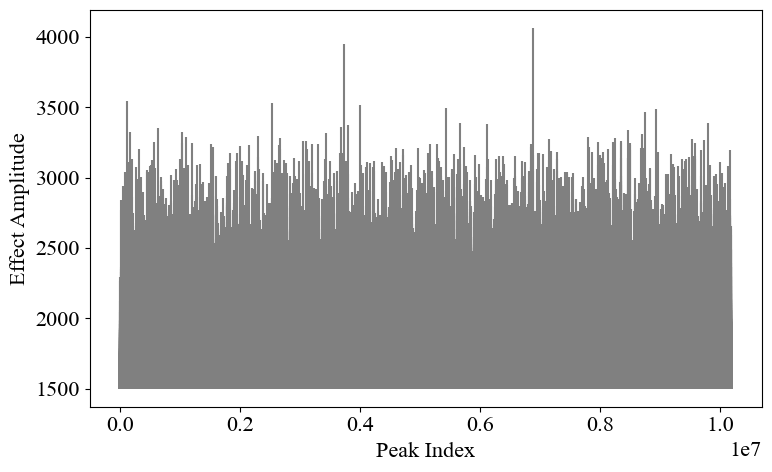

In [22]:
pb.plot.plot_POT_S(POT_output, threshold = 1500.0)

We define the following functions:

In [27]:
def fit_gp_exceedances(POT_data: pd.Series, u: float):
    y = POT_data[POT_data > u] - u
    # SciPy: genpareto(c=xi, loc=0, scale=sigma)
    xi, loc, sigma = genpareto.fit(y, floc=0)  # MLE
    return xi, sigma, y


def return_level(u, xi, sigma, n):
    # rate = exceedance rate P(X>u); n = number of over-threshold events
    # z_T = u + (sigma/xi) * [(n)**xi - 1]  for xi != 0
    if np.isclose(xi, 0.0):
        return u + sigma * np.log(n)
    return u + (sigma/xi) * (n**xi - 1)


def adjust_POT_threshold(data: pd.Series):

    qs = np.linspace(0.8, 0.999, 100)
    cands = np.quantile(data, qs)

    results = []
    for u in cands:
        xi, sigma, y = fit_gp_exceedances(data, u)
        residual = sum(y)/len(y)
        results.append((u, residual))

    results = pd.DataFrame(results, columns=["u", "residual"])

    return results


def plot_POT_threshold_adjustment(adjustment_result: pd.DataFrame):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))
    
    # Select the five columns and merge them into one Series
    u_data = adjustment_result["u"]
    residual_data = adjustment_result["residual"]

    # Plot vertical bars for each data point
    plt.plot(u_data, residual_data, color="gray")
    plt.xlabel("Threshold (kNm)")
    plt.ylabel("Mean residual (kNm)")

    # Adjust layout
    plt.tight_layout()

    # Show the figure
    plt.show()


def plot_POT_GP_pdf(POT_data: pd.Series, threshold: float, xi:float, sigma:float):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))

    # Histogram (empirical density)
    plt.hist(POT_data, bins=100, density=True, color="#AAAAAA", edgecolor="gray", alpha=0.8, label="Over-threshold events")

    # Plot the fitted GPD PDF
    if xi >= 0.0:
        x = np.linspace(threshold, POT_data.max(), 500)
    else:
        x = np.linspace(threshold, threshold - sigma/xi, 500)
    pdf = genpareto.pdf(x, c=xi, loc=threshold, scale=sigma)
    plt.plot(x, pdf, color="black", lw=2, label="GP distribution fitted")

    plt.xlabel("Mid-Span Bending Moment (kNm)")
    plt.ylabel("Density")

    plt.axvline(threshold, color="black", ls="--", lw=1.5, label="Threshold")
    
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_POT_GP_probability(POT_data: pd.Series, threshold: float, sigma:float, xi:float):

    def gp_variate(F, xi):
        # return -np.log(1 - F)
        if np.isclose(xi, 0.0):
            return -np.log(1 - F)
        else:
            return ((1 - F)**(-xi) - 1.0) / xi
        
    x = POT_data[POT_data > threshold] - threshold
    u = threshold
    n = len(POT_data)
    xs = np.sort(x)

    Fhat = np.arange(1, n+1, dtype=float) / (n + 1.0)

    beta = sigma
    qfn = lambda p: u + (beta/xi) * ((1 - pgrid)**(-xi) - 1.0) if not np.isclose(xi, 0.0) else u - beta * np.log(1-p)

    yemp = gp_variate(Fhat, xi)

    pgrid = np.linspace(0.00001, 0.999995, 2000)
    xfit = qfn(pgrid)
    yfit = gp_variate(pgrid, xi)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))

    plt.scatter(xs+u, yemp, s=25, color="gray", label="Over-threshold events")
    plt.plot(xfit, yfit, color="black", lw=2.5, label="GP distribution fitted")

    plt.xlabel("Mid-Span Bending Moment (kNm)")
    plt.ylabel("Standard GP Variate")

    plt.grid()

    plt.legend()
    plt.tight_layout()
    plt.show()



In peak-over-threshold (POT) extreme-value analysis, the “right” threshold (u) is the lowest value for which the exceedances behave like a Generalized Pareto (GP) distribution but still leave enough data to estimate reliably.

From the plot, it is likely that the initial threshold (1500.0 kNm) is too low since there are significant exceedances in the POT values.

Therefore, we test different threshold values and make a plot to visualize the adjustment.

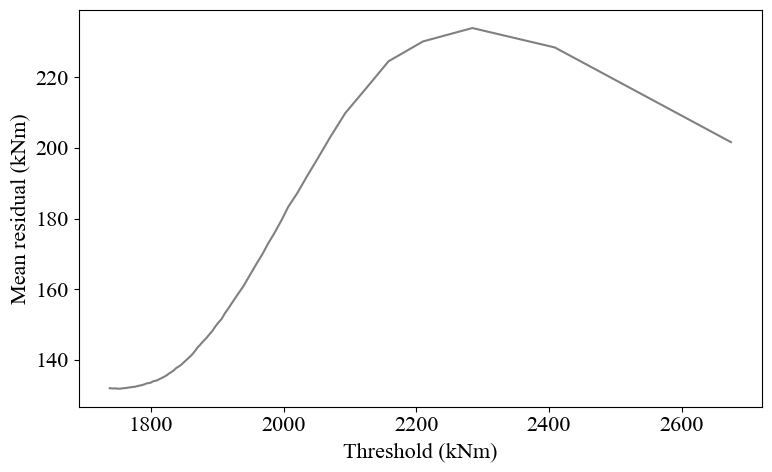

In [ ]:
plot_POT_threshold_adjustment(adjust_POT_threshold(POT_output["Peak Value"]))

According to the Chapter 3.3 of the book [Applied Extreme Value Statistics](https://rdcu.be/eBAHE), threshold = 2400 kNm deemed to be an appropriate choice for the analysis. 

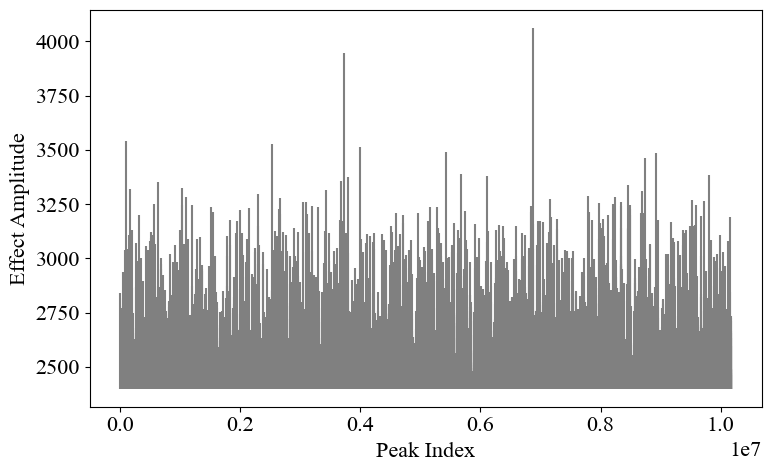

In [29]:
threshold = 2400.0
pb.plot.plot_POT_S(POT_output, threshold)

Validate the fitting with the new threshold.

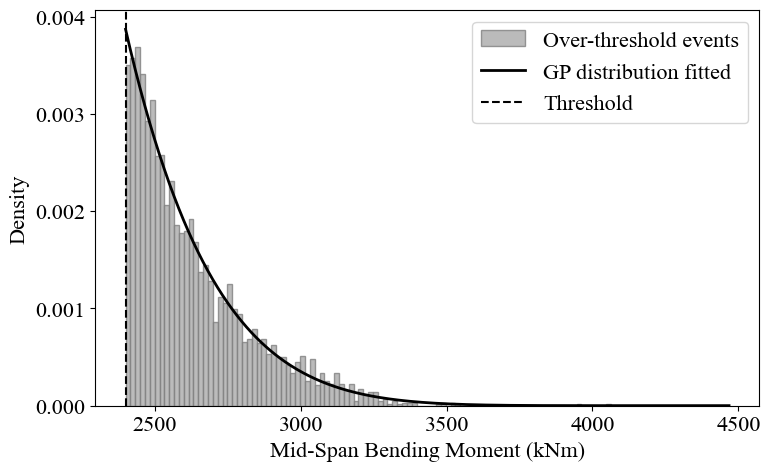

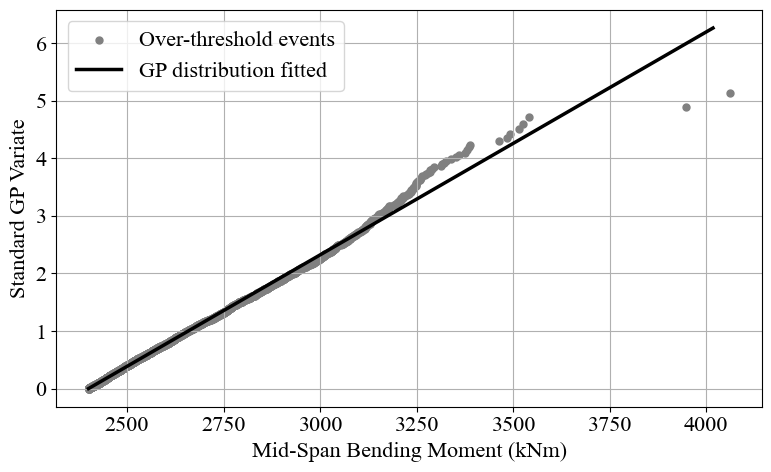

Fitted GP distribution parameters:
xi: -0.1250, mu: 2400, sigma: 258


In [30]:
POT_data = POT_output["Peak Value"][POT_output["Peak Value"] > threshold]

xi, sigma, y = fit_gp_exceedances(POT_data, threshold)
plot_POT_GP_pdf(POT_data, threshold, xi, sigma)
plot_POT_GP_probability(POT_data, threshold, sigma, xi)

print("Fitted GP distribution parameters:")
print(f"xi: {xi:.4f}, mu: {threshold:.0f}, sigma: {sigma:.0f}")

Finally, we can use the fitted GPD parameters to estimate the extreme value for a 100-year event.

In [31]:
n = len(POT_data)
rl100 = return_level(threshold, xi, sigma, n)
print(f"Extreme value for 100-year event: {rl100:.0f} kNm")

Extreme value for 100-year event: 3729 kNm
